# Uplift Data Challenge 10/30/19 - 11/07/19

Uplift is a lending company that finances trips sold through partnered travel providers. Two main problem that Uplift faces are: 
- How to predict if someone is going to repay their loan ?
- How to find the perfect loan amount for each client ? (It is sometimes interesting to lend more money than asked to encourage client to spend more to add confort to their vacation)

This is what we're going to see in this Notebook !


## Data inspection

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.decomposition import PCA
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import optuna #to optimize hyperparameter of our model
import shap #to interpret our model

Using TensorFlow backend.


Let's first inspect the data

In [2]:
#Loading the data
df = pd.read_csv('2019 Data Science Challenge Excel .csv')

In [3]:
df.describe()

,Unnamed: 0,default,order_amount,f1,f2,f3,f4,f5,f6,f7,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
count,156251.000000,156251.000000,156251.00000,156251.000000,156251.000000,156251.000000,156251.000000,156251.000000,156251.000000,156251.000000,...,156251.000000,156251.000000,1.562510e+05,156251.000000,156251.000000,156251.000000,156251.000000,156251.000000,156251.000000,156251.000000
mean,78125.000000,0.096422,1427.96884,648.305316,0.862234,8797.232991,1.836276,37.722018,1.094342,2.000531,...,1.065395,1.040851,1.047616e+05,1.092095,0.315742,5123.724219,0.252274,1.854548,1226.934121,14.467843
std,45105.922793,0.295170,1333.76795,60.447522,2.166462,15628.929250,2.334958,21.181450,0.339791,2.575812,...,0.274247,0.216389,7.356842e+05,0.335893,0.736964,2844.833253,0.761245,0.880259,1085.023353,5.462668
min,0.000000,0.000000,0.00000,500.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000e+00,1.000000,0.000000,181.000000,0.000000,0.000000,0.000000,0.000000
25%,39062.500000,0.000000,500.00000,604.000000,0.000000,0.000000,1.000000,21.000000,1.000000,0.000000,...,1.000000,1.000000,5.000000e+04,1.000000,0.000000,3175.000000,0.000000,1.000000,670.389613,11.000000
50%,78125.000000,0.000000,997.68000,642.000000,0.000000,2700.000000,1.000000,36.000000,1.000000,1.000000,...,1.000000,1.000000,7.500000e+04,1.000000,0.000000,4843.000000,0.000000,2.000000,1068.520860,15.000000
75%,117187.500000,0.000000,1903.21000,683.000000,1.000000,10400.000000,2.000000,53.000000,1.000000,3.000000,...,1.000000,1.000000,1.100000e+05,1.000000,0.000000,6635.000000,0.000000,2.000000,1564.969321,19.000000
max,156250.000000,1.000000,15000.00000,850.000000,122.000000,319705.000000,142.000000,99.000000,8.000000,49.000000,...,8.000000,5.000000,1.400000e+08,9.000000,15.000000,22209.000000,41.000000,11.000000,11791.333370,23.000000


In [4]:
df.dtypes

Unnamed: 0        int64
default           int64
order_amount    float64
f1                int64
f2                int64
f3                int64
f4                int64
f5                int64
f6                int64
f7                int64
f8                int64
f9                int64
f10               int64
f11               int64
f12               int64
f13               int64
f14               int64
f15               int64
f16               int64
f17               int64
f18               int64
f19             float64
f20               int64
dtype: object

Great news: 
- There is no missing values
- All features are numerical (some int features could be categorical feature that were encoded)

Notes: 
- "Unnamed: 0" appears to be a key to a loan, we'll need to remove it when training our model
- "order_amount" has a minimum of 0 which is an absurd loan-amount, we'll probably remove it

## Data preprocessing

Data Preprocessing has already been made so there isn't much left to do. Maybe something we could look at is the presence of outliers. 
There is a lot of features, we won't look at the outliers concerning potentially categorical data (we need all different categories represented) so we won't look at the int-type features, ie we'll only look at "order_amount", and "f19".

In [5]:
df[['order_amount', 'f19']].values

array([[ 698.28    , 2173.177806],
       [ 839.12    , 1748.692742],
       [ 619.62    , 1241.676439],
       ...,
       [1826.23    , 1371.298145],
       [1411.      , 1028.729231],
       [4069.8     ,    0.      ]])

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef6077bf28>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef607125f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef6077bb00>,
 'medians': [<matplotlib.lines.Line2D at 0x7fef60712c88>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fef60712fd0>,
 'means': []}

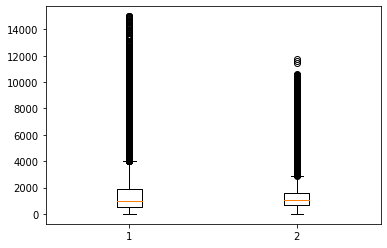

In [6]:
plt.boxplot(df[['order_amount', 'f19']].values)

In [7]:
df[df.f19 >10700]

,Unnamed: 0,default,order_amount,f1,f2,f3,f4,f5,f6,f7,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
19933,19933,0,1714.01,702,0,11900,1,39,1,2,...,1,1,50000,1,0,5199,0,1,11618.04885,22
36838,36838,0,630.95,677,2,3700,3,22,1,1,...,1,1,50000,1,0,1787,0,1,11791.33337,21
147164,147164,0,1609.10,589,0,16300,1,45,1,3,...,1,1,100000,1,5,8963,0,1,11443.61725,14


In [8]:
df[df.order_amount == 0]

,Unnamed: 0,default,order_amount,f1,f2,f3,f4,f5,f6,f7,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
57982,57982,0,0.0,595,0,0,1,9,1,0,...,1,1,20000,1,1,2760,0,1,1075.654411,17


There is no big outliers for the "order_amount" feature (only an absurd 0 value).
For "f19", it could be interesting to remove the three outliers.

In [9]:
df.drop(57982, inplace = True)
df.drop([19933, 36838, 147164], inplace = True)

Things we could do to improve our futur model but won't do to save us some time:
- looking at correlation between features to remove those "brings the same information" (like f2 and f4 who have a hig 0.91 correlation)
- removing features that have very small correlation rate or reducing the number of feature with a Principal Component Analysis
- creating new features from low correlated features

Furthermore, these tasks are easier to implement when knowing the meaning of the features, which isn't the case here.

# I/ First task: Identify or derive strong loan default predictors.

In [10]:
df.default.value_counts()

0    141181
1     15066
Name: default, dtype: int64

This is a binary classification problem, given all features, we want to predict the "default" value.
There are two important things to note:
- classes are unbalanced (about 10% of loan default), which means we have to be cautious when building our predicting model.
- given the context, there is an additional constraint which is: granting a loan to someone who can't pay back cost much more money for Uplift than not loaning to someone who could have paid back. In other words, we want to prefer false negative to false positive.


## 1) Quick loan default observation


Let's first look at our data and see which features seem to be closely correlated to a bad client.
Intuitively, features that could have big influence are house income, the value of outstanding loans (especially in the USA), the requested amount for the loan... But we miss names !



In [11]:
print(len(df[df.order_amount > 3500]))
df[df.order_amount > 3000].default.value_counts(normalize = True)

11393


0    0.889591
1    0.110409
Name: default, dtype: float64

In [12]:
print(len(df[df.order_amount < 300]))
df[df.order_amount<350].default.value_counts(normalize = True)

12561


0    0.937655
1    0.062345
Name: default, dtype: float64

As guessed, "order_amount" can help to predict the default value (6% of loan default for very little loan against 11% for a big loan).

In [13]:
df.groupby('default').mean()

,Unnamed: 0,order_amount,f1,f2,f3,f4,f5,f6,f7,f8,...,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20
default,,,,,,,,,,,,,,,,,,,,,
0,78051.000368,1413.439685,652.387226,0.812050,9318.014903,1.789412,38.722980,1.085706,2.088595,68.235917,...,1.060185,1.037930,106717.273479,1.084487,0.297880,5196.049306,0.250614,1.849767,1229.574069,14.501845
1,78821.795765,1564.235830,610.056418,1.332603,3917.289924,2.275521,28.344551,1.175295,1.175428,54.583898,...,1.114231,1.068233,86448.728196,1.163414,0.482809,4446.096310,0.267888,1.899575,1200.136600,14.148148


There are many features that suffer a big variation from a class to the other, such as:
- "f2": about 40% higher 
- "f7": 44% smaller
- "f9": 40% smaller
- "f15": 40% higher

Our winner is "f3" with a 58% decrease: it would make sense for this feature to be the household income. 

This gives us new tools to see if a client is probably a bad one. 

In [14]:
df.corr().default

Unnamed: 0      0.005044
default         1.000000
order_amount    0.033372
f1             -0.206706
f2              0.070923
f3             -0.101999
f4              0.061451
f5             -0.144627
f6              0.077825
f7             -0.104643
f8             -0.059718
f9             -0.079926
f10             0.087916
f11             0.058169
f12             0.041336
f13            -0.008132
f14             0.069358
f15             0.074078
f16            -0.077813
f17             0.006698
f18             0.016702
f19            -0.008015
f20            -0.019112
Name: default, dtype: float64

Features that are highly correlated to "default" are (in descending order):

In [15]:
df.corr().default.abs()[(df.corr().default.abs() > 0.09) & (df.corr().default.abs() < 1)].sort_values(ascending = False)

f1    0.206706
f5    0.144627
f7    0.104643
f3    0.101999
Name: default, dtype: float64

Since the correlation rate is negative, it means that the higher these values are, the most likely a client will repay his loan.

We could explore deeply each feature to be able to provide a real guide (similar to a decision tree). Instead, we'll build a tree-based model (using LGBM library) and then analyse it (using Shap library).

# 2) Our model

As previously said, we'll implement a model using Light GBM model with traditional Gradient Boosting Decision Tree algorithm. LGBM is known to be able to handle big data, quicker and to take lower memory to run. We'll use the Optuna library to optimize its hyperparameter and Shap library to analyse the features that explain the most our predictions.   

In [16]:
feature_cols = df.columns.drop(['default', 'Unnamed: 0'])
data_train, data_valid, Y_train, Y_valid = train_test_split(df[feature_cols], df['default'], test_size=1/10.0, random_state=0)

A few points concerning the fact that our data is unbalanced:
- We'll use a metric different from the traditionnal "accuracy": "auc". Accuracy would be misleading in our situation since a trivial model that predicts 0 to every input will have a 90% accuracy.
- We'll add a hyperparameter to tell our model that the data is unbalanced

We could also oversample the 1-class using the SMOTE library for instance, but we'll skip it since the model would normally takes into consideration the unbalanced data.

In [17]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 1,
          'num_leaves' : 5,
          'max_depth' : -1,
          'n_estimators' : 100,
          'min_child_samples': 200, 
          'min_child_weight': 0.5,
          'reg_alpha': 1,
          'reg_lambda': 1,
          'subsample': 0.5,
          'verbose' : -1,
          'num_threads' : 2,
          'is_unbalance' : True
}

def train_model(train, valid, Y_train, Y_valid, param=None, printbool = True):
    
    """
    Training our LGBM model and printing some metrics result (AUC is the most important one)
    Args:
        train (pd.DataFrame): training data
        valid (pd.DataFrame): validation data
        Y_train (pd.DataFrame): training label
        Y_valid (pd.DataFrame): validation label
        param (dict): hyperparameter of our model
        printbool (boolean): Whether or not we want to print and plot the confusion matrix
    Returns:
        valid_score (float): AUC score on validation data
    """
    dtrain = lgb.Dataset(train, label=Y_train)
    dvalid = lgb.Dataset(valid, label=Y_valid)
    
    num_round = 1000
    print("Training model!")
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)
    
    train_pred = bst.predict(train)
    train_score = metrics.roc_auc_score(Y_train, train_pred)
    print(f"Train AUC score: {train_score}")
    valid_pred = bst.predict(valid)
    valid_score = metrics.roc_auc_score(Y_valid, valid_pred)
    print(f"Validation AUC score: {valid_score}")
    
    threshold = 0.5
    train_pred = (train_pred > threshold)
    train_accuracy = metrics.accuracy_score(train_pred, Y_train)
    print(f"Train Accuracy score: {train_accuracy}")
    valid_pred = (valid_pred > threshold)
    valid_accuracy = metrics.accuracy_score(valid_pred, Y_valid)
    print(f"Validation Accuracy score: {valid_accuracy}")
    
    if printbool:
        conf_mat1 = metrics.confusion_matrix(y_true=Y_train, y_pred=train_pred)
        print('Confusion matrix:\n', conf_mat1)
        labels = ['Class 0', 'Class 1']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_mat1, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()

        conf_mat2 = metrics.confusion_matrix(y_true=Y_valid, y_pred=valid_pred)
        print('Confusion matrix:\n', conf_mat2)
        labels = ['Class 0', 'Class 1']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_mat2, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()
    
    return valid_score
    

Training model!


/home/resplandy/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Train AUC score: 0.7770203557484768
Validation AUC score: 0.7618375321770219
Train Accuracy score: 0.9041472884754875
Validation Accuracy score: 0.902144
Confusion matrix:
 [[127025     59]
 [ 13420    118]]


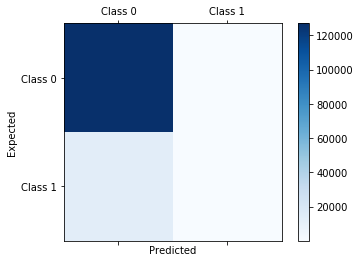

Confusion matrix:
 [[14089     8]
 [ 1521     7]]


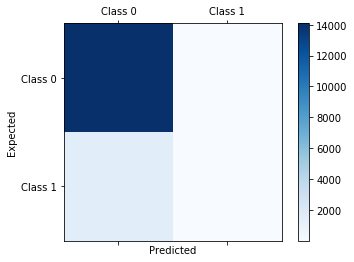

0.7618375321770219

In [18]:
train_model(data_train, data_valid, Y_train, Y_valid, param = params)

As we could have expected, our model understood that the 1-class was underrepresented and has been trained to almost always predict 0 (which makes a great accuracy but is useless in our situation). However, our confusion matrix has been plotted with a threshold of 0.5, which could be adjusted in order to reduce False Positive in favor of False Negative.

The important metric here is the AUC which is equal to 0.76.

Before interpreting our model, we'll try to optimize its hyperparameter which was chosen quite randomly.

In [19]:
def objective(trial):    
    
    
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0) 
    num_leaves = trial.suggest_int('num_leaves', 5, 200) 
    max_depth = trial.suggest_int('max_depth', -1, 10) 
    n_estimators = trial.suggest_int('n_estimators', 10, 200) 
    min_child_samples = trial.suggest_int('min_child_samples', 20, 500) 
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.0, 1.0) 
    reg_alpha = trial.suggest_uniform('reg_alpha', 0.0, 2.0) 
    reg_lambda = trial.suggest_int('reg_lambda', 1, 10) 
    subsample = trial.suggest_uniform('subsample', 0.0, 1.0) 
    num_threads = trial.suggest_int('num_threads', 1, 10) 
    
    params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : colsample_bytree,
          'num_leaves' : num_leaves,
          'max_depth' : max_depth,
          'n_estimators' : n_estimators,
          'min_child_samples': min_child_samples, 
          'min_child_weight': min_child_weight,
          'reg_alpha': reg_alpha,
          'reg_lambda': reg_lambda,
          'subsample': subsample,
          'verbose' : -1,
          'num_threads' : num_threads, 
          'is_unbalance' : True
    }
    
    return -train_model(data_train, data_valid, Y_train, Y_valid, param = params, printbool = False)

In [ ]:
study = optuna.create_study()
study.optimize(objective, timeout=1000);

(I cleared the previous output because it took too much space) 
We improve our AUC score which equals now 0.77 ! The improvement is little, we could have had done without it but it didn't take that much time and it sometimes does great improvement. 

In [21]:
#Lets save our model with the best hyperparameter.

params = study.best_params
params['verbose'] = -1
params['metric'] = 'auc'
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['is_unbalance'] = True

dtrain = lgb.Dataset(data_train, label=Y_train)
dvalid = lgb.Dataset(data_valid, label=Y_valid)
    
num_round = 1000
print("Training model!")
bst = lgb.train(params, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=20, verbose_eval=False)

valid_pred = bst.predict(data_valid)
valid_score = metrics.roc_auc_score(Y_valid, valid_pred)
print(f"Validation AUC score: {valid_score}")

Training model!


/home/resplandy/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Validation AUC score: 0.7683058517147645


## 3) Analyzing the model

To analyse our model, we'll use the SHAP library. SHAP uses coalitional game theory to compute the contribution of each feature to the prediction, which allows to explain each prediction.

In [22]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(data_valid)


/home/resplandy/anaconda3/lib/python3.7/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Let's take a look at a single prediction to better understand how this library works:

In [23]:
i = 2
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][i], features = data_valid.iloc[i], link = 'logit')

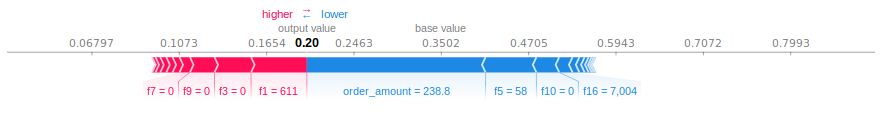

In [3]:
#The graph don't show up when used by another user 
from IPython.display import Image
Image("Screenshot from 2019-11-04 09-15-34.png")

The base value is the same for every prediction: it is 0.36. Then, each feature add its contribution to the prediction. Here, the output value is 0.21. 
On this single prediction, there is a notable thing: "f1", "order_amount", "f5" and "f3" are the main features that determine the output value.
To check if that generalizes itself for every prediction in our validation data, we use the "shap.summary_plot" function.


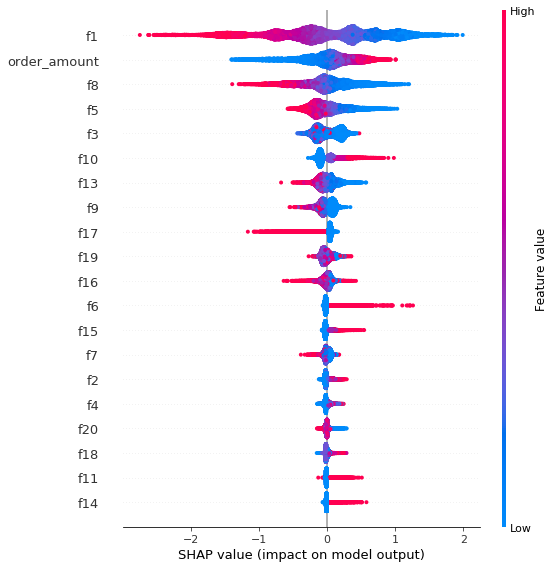

In [24]:
shap.summary_plot(shap_values[1], data_valid)

What can we say about this graph?
- "f1" is the most valuable feature for predicting the output: both when it is low and when it is high, it often results in very high SHAP value (the point cloud is widespread)
- "Order_amount" and "f8" are the next two important features, and they behave like "f1": the shape of the point cloud is symetric which means that both low and high value are decisive for our prediction.

Then there is a list of features which are anti-symetric, which means they only have impact on the prediction when the value is high or (exclusive sense) low. There is 3 main categories resulting from this:
- Category 1: when those features are high, they can have big influence on testifying that the client will refund his loan. "f17" is the only one in this category.
This category interests us less since we want to find tools to help us to detect bad clients (and our model naturally tends to perceive a client as good so we don't really need features that go in the same direction). 
- Category 2: when those features are high, they can be decisive to predict loan default ("f10", "f6"). 

- Category 3: when those features are low, they can be decisive to predict loan default ("f5").

Then there are a lot of features that we could maybe get rid of, like "f3", "f16". With these features, a high or low value can't help us at all to make our prediction. 


The summary plot above gives a lot of information. But as we have seen, equally high values of "f1" for instance can result in a wide range of SHAP value. To better understand how each of the features works, we can examine a single feature and see how it impacts the model's prediction across all the samples, using the function shap.dependence_plot. This will plot for a given feature the SHAP value associated, coloring each point according to another feature value which seems to explain some of the dispersion of the point cloud.

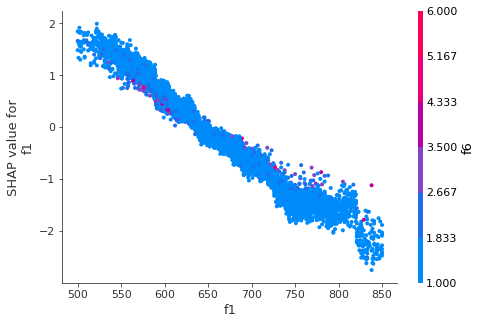

In [25]:
#Instead of plotting each feature, we'll just keep the interesting one (after having seen every one of them)

#for i in range(1,20):
#    shap.dependence_plot("f"+str(i), shap_values[1], data_valid)
#shap.dependence_plot("order_amount", shap_values[1], data_valid)

L = ["f1", "f6","f14", "order_amount"]

shap.dependence_plot(L[0], shap_values[1], data_valid) 

This graph shows that "f1" is a great indicator concerning the default value:
- First, the relationship between SHAP value for "f1" and "f1" is almost linear
- Second, for an equal value of f1, the shape value is relatively stable (+/- 0.25 for low values of f1)

==> Values of f1 between 500 and 550 should definitely by a loan default warning !

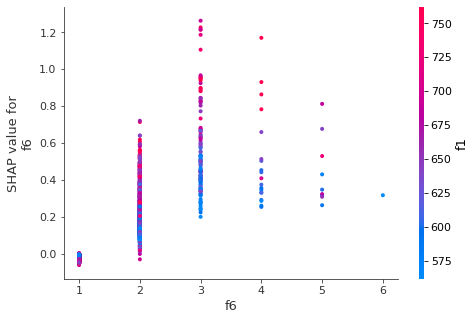

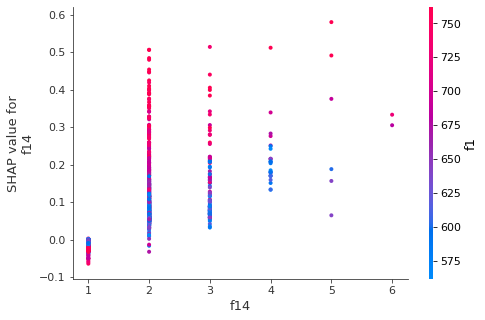

In [26]:
for x in L[1:3]:
    shap.dependence_plot(x, shap_values[1], data_valid)

These graphs concern the categorical features "f6", "f12". 
When "f6" and/or "f14" is different from 1, and "f1" is high, it results in high SHAP value. But a high value of "f1" will induce a low associated SHAP value, and since "f1" is the most important feature concerning SHAP value, we don't want that. 
However, when "f6" and/or "f14" is different 1, and f1 is low, we still have a positive significant SHAP value for these features.

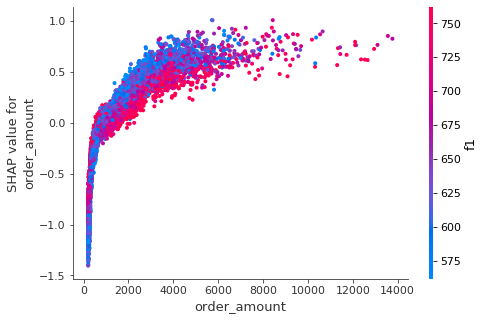

In [27]:
shap.dependence_plot(L[3], shap_values[1], data_valid) 

This graph is very satisfying, cause it shows that for equal order_amount, a low "f1" value induces a higher SHAP value for "order_amount".

In conclusion, things that could warn us of a bad client are (in descending order of importance):
- a low f1 value
- a big order_amount value (more than 2000) combined wih a low f1 value
- a low f8 value (see summary plot)
- f6 and f14 different from 1

# Second Task: Create a procedure to determine the loan limit for a given applicant.

Although the model created for the first task isn't perfect, we'll try to use it to create this procedure.
To simplify the problem, we are going to suppose that: 
- the interest rate (over the whole refund period) is constant for every client and loan amount, we note it r
- a client either repay the whole loan or nothing
- (our model has been improved)

For a user x, and a loan amount of Q, we can calculate the expectation of the gain of Uplift

$$
 \mathbb{E}_{x, Q}(x) = \mathbb{P}_{x, Q}(default = 0) \times S \times r + \mathbb{P}_{x, Q}(default = 1) \times (-S)  $$
 
In our problem, we want the expectation to be positive which means that:

$$  r \geq \frac{\mathbb{P}_{x, Q}(default = 1)}{\mathbb{P}_{x, Q}(default = 0)}$$

As we have seen previously, the lower the "order_amount" feature is, the bigger is the probability of paying back the loan. The procedure we'll use, is based on this observation: while r doesn't satisfy the inequality, we manually reduce the value of "order_amount" and predict again with the new features the probabily of loan default.


In [28]:
def loan_limit(index, r):
    row = df.loc[index].drop(['Unnamed: 0', 'default']) #we normally don't have 'default' in our situation
    amount = df.loc[index]['order_amount']
    amount_fix = amount
    p1 = bst.predict(row)[0]
    print('This client has a probability '+ str(p1)+' of not paying back the ' + str(amount_fix) + ' requested')
    if r > (p1 / (1-p1)): #we can lend the client even more money than he wanted
        print("We can lend what the client requests and even more !")
        res = True
        while(res and amount < 2*amount_fix):
            amount = amount * 1.05 
            row['order_amount'] = amount
            p1 = bst.predict(row)[0]
            res = (r > (p1 / (1-p1)) )
    else:
        print("We can't lend the " + str(amount_fix) + " that the client requests !")
        res = False
        while (not res and amount > amount_fix * 0.1):
            amount = amount / 1.05
            row['order_amount'] = amount
            p1 = bst.predict(row)[0]
            res = (r > (p1 / (1-p1)) )
        if amount < amount_fix * 0.1:
            return ("We can't lend anything to this client with an interest rate of " + str(r))
    
    print("We can lend him "+str(amount) + " with an interest rate of " + str(r))
    return amount
        

Here are a few example of outputs of that function ! 

In [29]:
loan_limit(50, 0.10)

/home/resplandy/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:497: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


This client has a probability 0.10678711566114811 of not paying back the 1471.57 requested
We can't lend the 1471.57 that the client requests !
We can lend him 1334.7573696145123 with an interest rate of 0.1


1334.7573696145123

In [30]:
loan_limit(100, 0.10)

This client has a probability 0.8019711295941294 of not paying back the 495.29 requested
We can't lend the 495.29 that the client requests !


"We can't lend anything to this client with an interest rate of 0.1"

In [31]:
loan_limit(500, 0.2)

This client has a probability 0.1599596111590001 of not paying back the 1250.47 requested
We can lend what the client requests and even more !
We can lend him 1447.5753337500003 with an interest rate of 0.2


1447.5753337500003

In conclusion, this procedure seems to work but there is a few requirements with this approach: first, this approach is really dependent on the model, which must be very performant (with AUC-metric). We also need the prediction or our model to be a decreasing function of the "order_amount" which isn't necessarily the case, and which is hard to see on a tree-based model (while that would be clear on a linear regression model). 